In [1]:
import sys
import os
sys.path.append("../..")

from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import RandomIntervalSDOMLDataset, RandomIntervalSDOMLDataModule 
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS

In [2]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [3]:
cfg.data.sdoml.sub_directory.eve

'EVE_legacy.zarr"'

In [4]:
data_module = RandomIntervalSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),    
    eve_path = None,
    components  = cfg.data.sdoml.components,
    wavelengths = cfg.data.sdoml.wavelengths,
    ions        = cfg.data.sdoml.ions,
    frequency   = cfg.data.sdoml.frequency,
    batch_size  = 2,
    num_workers = 2,
    num_frames  = 2,
    blosc_cache = "/home/rlx/blosc_cache",
    start_date = '2010-09-01',
    end_date   = '2010-12-31',
    dim = True,
    sampling_period = '5days',
    val_months  = cfg.data.month_splits.val,
    test_months = cfg.data.month_splits.test,
    holdout_months = cfg.data.month_splits.holdout,
    cache_dir = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [5]:
data_module.aligndata

,idx_131A,idx_1600A,idx_1700A,idx_171A,idx_193A,idx_211A,idx_304A,idx_335A,idx_94A,idx_Bx,idx_By,idx_Bz
Time,,,,,,,,,,,,
2010-09-01 00:00:00,1336,1338,1339,1338,1336,1337,1336,1336,1337,8513,8513,8513
2010-09-01 00:12:00,1337,1339,1340,1339,1337,1338,1337,1337,1338,8418,8418,8418
2010-09-01 00:24:00,1339,1342,1343,1341,1339,1340,1339,1339,1339,8504,8504,8504
2010-09-01 00:36:00,1341,1344,1345,1343,1341,1342,1341,1341,1342,8461,8461,8461
2010-09-01 00:48:00,1343,1346,1347,1345,1343,1344,1343,1343,1344,8417,8417,8417
...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-31 23:00:00,13890,13897,13035,13888,13898,13887,13889,13898,13646,17209,17209,17209
2010-12-31 23:12:00,13892,13898,13036,13890,13900,13889,13891,13900,13648,17232,17232,17232
2010-12-31 23:24:00,13894,13901,13039,13892,13902,13891,13893,13902,13649,17231,17231,17231


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(12, 6, 5, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, stride=2)
        self.fc1 = nn.Linear(1568, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [7]:
dltrain = data_module.train_dataloader()

In [8]:
len(dltrain)

2312

In [9]:
model = Net().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


In [ ]:
num_epochs = 10
lossh = []
for epoch in range(num_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['dimmed_image_stack'].type(torch.float)[:,:,0,:,:].cuda() # ignore time frames, just get the first one
        f = batch['dim_factor'].type(torch.float).cuda()

        # run model
        o = model(x)

        # compute loss
        loss = torch.sqrt( torch.mean((f-o)**2 ) )
                
        # backpropage and sigmoidupdate
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in model.parameters()])    
        lossm = np.mean(lossh[-100:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")


In [ ]:
def ploth(h, name='loss', ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f'smoothed {name}'] = lossp[name].rolling(100).mean()
    lossp.plot(alpha=.5, ax=ax)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)

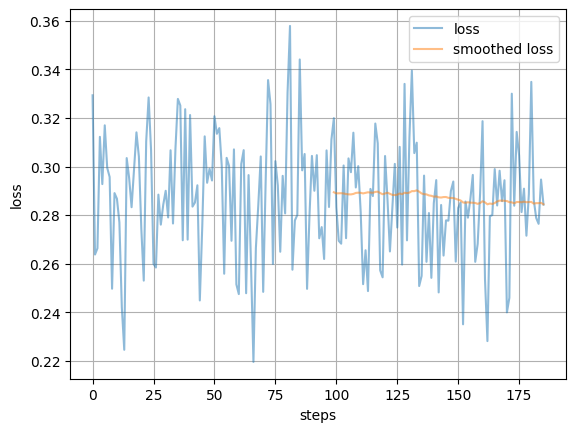

In [47]:
ploth(lossh)

In [143]:
data_module.eve_data

In [13]:
    def get_aia_image(self, idx, aligned_samples):
        """Get AIA image for a given index.
        Returns a numpy array of shape (num_wavelengths, num_frames, height, width).
        """
        aia_image_dict = {}
        for wavelength in self.wavelengths:
            aia_image_dict[wavelength] = []
            for _, idx_row_element in aligned_samples.iterrows():
                idx_wavelength = idx_row_element[f"idx_{wavelength}"]
                year = str(idx_row_element.name.year)
                img = self.aia_data[year][wavelength][idx_wavelength, :, :]

                if self.mask is not None:
                    img = img * self.mask

                aia_image_dict[wavelength].append(img)

                if self.normalizations:
                    aia_image_dict[wavelength][-1] -= self.normalizations["AIA"][
                        wavelength
                    ]["mean"]
                    aia_image_dict[wavelength][-1] /= self.normalizations["AIA"][
                        wavelength
                    ]["std"]

        aia_image = np.array(list(aia_image_dict.values()))

        return aia_image
    
    def xget_aia_image(self, idx, aligned_samples):
        """Get AIA image for a given index.
        Returns a numpy array of shape (num_wavelengths, num_frames, height, width).
        """
        
        aia_image = np.r_[[load_aia(self.aia_data, idx_row_element, self.wavelengths) \
                           for _,idx_row_element in aligned_samples.iterrows()]]
                    
        if self.mask is not None:
            aia_image *= self.mask[np.newaxis, np.newaxis, :, :]        

        if self.normalizations:
            aia_image -=  self.aia_means[np.newaxis, :, np.newaxis, np.newaxis]
            aia_image /= self.aia_stdevs[np.newaxis, :, np.newaxis, np.newaxis]    
                        
        aia_image = np.transpose(aia_image, [1,0,2,3])
        return aia_image
    
    def load_aia(aia_data, align_data_row_element, wavelengths):
        r = []
        for wavelength in wavelengths:
            idx_wavelength = align_data_row_element[f"idx_{wavelength}"]
            year = str(align_data_row_element.name.year)

            img = aia_data[year][wavelength][idx_wavelength, :, :]
            r.append(img)
        return np.r_[r]

In [14]:
#mask = self.mask
#self.mask = None

In [15]:
#self.mask = mask

In [16]:
idx = 10222
self = data_module.train_ds

self.aia_means  = np.r_[[self.normalizations["AIA"][wavelength]["mean"] for wavelength in self.wavelengths]]
self.aia_stdevs = np.r_[[self.normalizations["AIA"][wavelength]["std"] for wavelength in self.wavelengths]]


item = self.aligndata.iloc[idx]
sampling_df = self.aligndata_full.loc[item.name - pd.Timedelta(self.sampling_period): item.name - pd.Timedelta("1sec")]
aligned_samples = pd.concat([sampling_df.sample(self.num_frames-1), pd.DataFrame([item])])        
timestamps = [i.strftime("%Y-%m-%d %H:%M:%S") for i in aligned_samples.index]

k1 = get_aia_image(self, idx, aligned_samples)
k2 = xget_aia_image(self, idx, aligned_samples)
np.allclose(k1, k2, atol=1e-6)

True

In [94]:
k1.shape

(9, 2, 512, 512)

In [95]:
k2.shape

(9, 2, 512, 512)

In [17]:
aligned_samples

,idx_131A,idx_1600A,idx_1700A,idx_171A,idx_193A,idx_211A,idx_304A,idx_335A,idx_94A,idx_Bx,idx_By,idx_Bz
2010-09-03 01:00:00,3614,3615,3616,3615,3614,3614,3614,3614,3614,8890,8890,8890
2010-09-09 14:24:00,143,144,144,143,143,143,143,143,142,8020,8020,8020


In [19]:
align_data_row_element = aligned_samples.iloc[0]
wavelengths = self.wavelengths

In [21]:
align_data_row_element.name.strftime("%Y-%m-D

<bound method Timestamp.strftime of Timestamp('2010-09-03 01:00:00')>

In [26]:
align_data_row_element.name.strftime("%Y-%m-%d_%H:%M:%S")

'2010-09-03_01:00:00'

In [27]:
"-".join(wavelengths)

'131A-1600A-1700A-171A-193A-211A-304A-335A-94A'

In [28]:
import blosc

In [57]:
def load_blosc_file(blosc_cache, event_date, setname, elements):
    datestr = event_date.strftime("%Y-%m-%d_%H:%M:%S")
    elemsstr = "-".join(elements)
    
    file_name = f"{blosc_cache}/{datestr}__{setname}__{elemsstr}.blosc"
    print ("file name", file_name)
    
    if os.path.isfile(file_name):
        with open(file_name, "rb") as f:
            arr = blosc.unpack_array(f.read())
        return arr
    return None

In [60]:
def save_blosc_file(blosc_cache, event_date, setname, elements, array):
    datestr = event_date.strftime("%Y-%m-%d_%H:%M:%S")
    elemsstr = "-".join(elements)
    
    file_name = f"{blosc_cache}/{datestr}__{setname}__{elemsstr}.blosc"
    print ("file name", file_name)
    with open(file_name, "wb") as f:
        f.write(blosc.pack_array(array))


In [61]:
save_blosc_file("/home/rlx/blosc_cache/", align_data_row_element.name, 'aia', self.wavelengths, k1)

file name /home/rlx/blosc_cache//2010-09-03_01:00:00__aia__131A-1600A-1700A-171A-193A-211A-304A-335A-94A.blosc


In [62]:
kk = load_blosc_file("/home/rlx/blosc_cache/", align_data_row_element.name, 'aia', self.wavelengths)

file name /home/rlx/blosc_cache//2010-09-03_01:00:00__aia__131A-1600A-1700A-171A-193A-211A-304A-335A-94A.blosc


In [63]:
!ls /home/rlx/blosc_cache/

2010-09-03_01:00:00__131A-1600A-1700A-171A-193A-211A-304A-335A-94A.blosc
2010-09-03_01:00:00__aia__131A-1600A-1700A-171A-193A-211A-304A-335A-94A.blosc


In [50]:
kk